# The Application of Quantum Neural Network in NLP

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_qnn_for_nlp.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/case_library/mindspore_qnn_for_nlp.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/case_library/qnn_for_nlp.ipynb)

## Overview

Word embedding plays a key role in natural language processing. It embeds a high-dimension word vector to lower dimension space. When more information is added to the neural network, the training task will become more difficult. By taking advantage of the characteristics of quantum mechanics (e.g., state superposition and entanglement), a quantum neural network can process such classical information during training, thereby improving the accuracy of convergence. In the following, we will build a simple mixed quantum neural network for completing word embedding task.

Import relevant dependencies of the tutorial.

In [1]:
import numpy as np
import time
import mindspore as ms
import mindspore.ops as ops
import mindspore.dataset as ds
from mindspore import nn
from mindquantum.framework import MQLayer
from mindquantum.core.gates import RX, RY, X, H
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.operators import Hamiltonian, QubitOperator

This tutorial implements a [CBOW model](https://blog.csdn.net/u010665216/article/details/78724856), which predicts a word based on its position. For example, "I love natural language processing", this sentence can be divided by five words, which are \["I", "love", "natural", "language", "processing"\]. When the selected window is 2, the task to be completed would be to predict the word "natural" given \[“I”, “love”, “language”, “processing”\]. In the following, we will build a quantum neural network for word embedding to deal with the this task.

![quantum word embedding](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/qcbow.png)

Here, the encoding information of "I", "love", "language", and "processing" will be encoded to the quantum circuit. This quantum circuit to be trained consists of four Ansatz circuits. At last, we measure the qubit in the $\text{Z}$ base vector for the quantum circuit end. The number of measured qubits is determined by the embedded dimenson.

## Data Pre-processing

It is necessary to form a dictionary for the setence to be processed and determine the samples according to the size of the window.

In [2]:
def GenerateWordDictAndSample(corpus, window=2):
    all_words = corpus.split()
    word_set = list(set(all_words))
    word_set.sort()
    word_dict = {w: i for i, w in enumerate(word_set)}
    sampling = []
    for index, _ in enumerate(all_words[window:-window]):
        around = []
        for i in range(index, index + 2*window + 1):
            if i != index + window:
                around.append(all_words[i])
        sampling.append([around, all_words[index + window]])
    return word_dict, sampling

word_dict, sample = GenerateWordDictAndSample("I love natural language processing")
print(word_dict)
print('word dict size: ', len(word_dict))
print('samples: ', sample)
print('number of samples: ', len(sample))

{'I': 0, 'language': 1, 'love': 2, 'natural': 3, 'processing': 4}
word dict size:  5
samples:  [[['I', 'love', 'language', 'processing'], 'natural']]
number of samples:  1


According to the above information, the size of the dictionary is 5 and it is enough to select a sample.

## Encoding Circuit

For simplification, we use the $\text{RX}$ rotation gate to construct the encoding circuit. The structure is as follows.

![encoder circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/encoder.png)

We apply a $\text{RX}$ rotation gate to each quantum qubit.

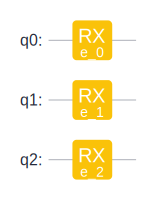

In [3]:
def GenerateEncoderCircuit(n_qubits, prefix=''):
    if prefix and prefix[-1] != '_':
        prefix += '_'
    circ = Circuit()
    for i in range(n_qubits):
        circ += RX(prefix + str(i)).on(i)
    return circ.as_encoder()

GenerateEncoderCircuit(3, prefix='e').svg()

$\left|0\right>$ and $\left|1\right>$ are used to mark the two states of a two-level qubit. According to the state superposition theory, qubit can also be in the superposition of these two states:

$$\left|\psi\right>=\alpha\left|0\right>+\beta\left|1\right>$$

For the quantum state of a $n$ bits, it can be in a $2^n$ Hilbert space. For the dictionary composed by the above 5 words, we only need $\lceil \log_2 5 \rceil=3$ qubits to complete the encoding task, which demonstrates the superiority of quantum computing.

For example. given the word "love" in the above dictionary, its corresponding label is 2, represented by `010` in the binary format. We only need to set `e_0`, `e_1`, and `e_2` to $0$, $\pi$, and $0$ respectively.

In [4]:
from mindquantum.simulator import Simulator

n_qubits = 3  # number of qubits of this quantum circuit
label = 2  # label need to encode
label_bin = bin(label)[-1:1:-1].ljust(n_qubits, '0')  # binary form of label
label_array = np.array([int(i) * np.pi for i in label_bin]).astype(np.float32)  # parameter value of encoder
encoder = GenerateEncoderCircuit(n_qubits, prefix='e')  # encoder circuit
encoder_params_names = encoder.params_name  # parameter names of encoder

print("Label is: ", label)
print("Binary label is: ", label_bin)
print("Parameters of encoder is: \n", np.round(label_array, 5))
print("Encoder circuit is: \n")
print(encoder)
print("Encoder parameter names are: \n", encoder_params_names)

state = encoder.get_qs(pr=dict(zip(encoder_params_names, label_array)))
amp = np.round(np.abs(state) ** 2, 3)

print("Amplitude of quantum state is: \n", amp)
print("Label in quantum state is: ", np.argmax(amp))

Label is:  2
Binary label is:  010
Parameters of encoder is: 
 [0.      3.14159 0.     ]
Encoder circuit is: 

      ┏━━━━━━━━━┓   
q0: ──┨ RX(e_0) ┠───
      ┗━━━━━━━━━┛   
      ┏━━━━━━━━━┓   
q1: ──┨ RX(e_1) ┠───
      ┗━━━━━━━━━┛   
      ┏━━━━━━━━━┓   
q2: ──┨ RX(e_2) ┠───
      ┗━━━━━━━━━┛   
Encoder parameter names are: 
 ['e_0', 'e_1', 'e_2']
Amplitude of quantum state is: 
 [0. 0. 1. 0. 0. 0. 0. 0.]
Label in quantum state is:  2


Through the above verification, for the data with label 2, the position where the largest amplitude of the quantum state is finally obtained is also 2. Therefore, the obtained quantum state is exactly the encoding information of input label. We summarize the process of generating parameter values through data encoding information into the following function.

In [5]:
def GenerateTrainData(sample, word_dict):
    n_qubits = int(np.ceil(np.log2(1 + max(word_dict.values()))))
    data_x = []
    data_y = []
    for around, center in sample:
        data_x.append([])
        for word in around:
            label = word_dict[word]
            label_bin = bin(label)[-1: 1: -1].ljust(n_qubits, '0')
            label_array = [int(i)*np.pi for i in label_bin]
            data_x[-1].extend(label_array)
        data_y.append(word_dict[center])
    return np.array(data_x).astype(np.float32), np.array(data_y).astype(np.int32)

GenerateTrainData(sample, word_dict)

(array([[0.       , 0.       , 0.       , 0.       , 3.1415927, 0.       ,
         3.1415927, 0.       , 0.       , 0.       , 0.       , 3.1415927]],
       dtype=float32),
 array([3], dtype=int32))

According to the above result, we merge the encoding information of these 4 input words into a longer vector for further usage of the neural network.

## Ansatz Circuit

There is a variety of selections for the Ansatz circuits. We select the below quantum circuit as the Ansatz circuit. A single unit of the Ansatz circuit consists of a [RY](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RY.html) gate and a [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html) gate. The full Ansatz circuit can be obtained by repeating $p$ times over this single unit.

![ansatz circuit](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/ansatz.png)

The following function is defined to construct the Ansatz circuit.

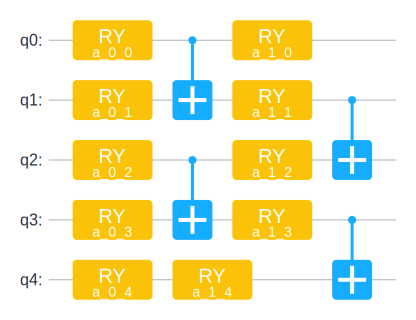

In [6]:
def GenerateAnsatzCircuit(n_qubits, layers, prefix=''):
    if prefix and prefix[-1] != '_':
        prefix += '_'
    circ = Circuit()
    for l in range(layers):
        for i in range(n_qubits):
            circ += RY(prefix + str(l) + '_' + str(i)).on(i)
        for i in range(l % 2, n_qubits, 2):
            if i < n_qubits and i + 1 < n_qubits:
                circ += X.on(i + 1, i)
    return circ.as_ansatz()

GenerateAnsatzCircuit(5, 2, 'a').svg()

## Measurement

We treat the measurements of different qubits as the data after dimension reduction. This process is similar to qubit encoding. For example, when we want to reduce the dimension of the word vector to 5, we can process the data in the 3rd dimension as follows:

- 3 in the binary format is 00011.
- Measure the expectation value of the Z0Z1 hams at the quantum circuit end.

The below function gives the hams to generate the data in all dimension, where n_qubits represents the number of qubits, dims represents the dimension of word embedding.

In [7]:
def GenerateEmbeddingHamiltonian(dims, n_qubits):
    hams = []
    for i in range(dims):
        s = ''
        for j, k in enumerate(bin(i + 1)[-1:1:-1]):
            if k == '1':
                s = s + 'Z' + str(j) + ' '
        hams.append(Hamiltonian(QubitOperator(s)))
    return hams

GenerateEmbeddingHamiltonian(5, 5)

[1 [Z0], 1 [Z1], 1 [Z0 Z1], 1 [Z2], 1 [Z0 Z2]]

## Quantum Word Embedding Layer

The quantum word embedding layer combines the above-mentioned encoding quantum circuit, the quantum circuit to be trained, and the measurement of hams. `num_embedding` words can be embedded into a word vector with `embedding_dim` dimension. Here, a Hadamard gate is added at the beginning of the quantum circuit. The initialization state is set to average superposition state for improving the representation ability of the quantum neural network.

In the following, we define a quantum embedding layer and it returns a quantum circuit simulation operator.

In [8]:
def QEmbedding(num_embedding, embedding_dim, window, layers, n_threads):
    n_qubits = int(np.ceil(np.log2(num_embedding)))
    hams = GenerateEmbeddingHamiltonian(embedding_dim, n_qubits)
    circ = Circuit()
    circ = UN(H, n_qubits)
    encoder_param_name = []
    ansatz_param_name = []
    for w in range(2 * window):
        encoder = GenerateEncoderCircuit(n_qubits, 'Encoder_' + str(w))
        ansatz = GenerateAnsatzCircuit(n_qubits, layers, 'Ansatz_' + str(w))
        encoder.no_grad()
        circ += encoder
        circ += ansatz
        encoder_param_name.extend(encoder.params_name)
        ansatz_param_name.extend(ansatz.params_name)
    grad_ops = Simulator('mqvector', circ.n_qubits).get_expectation_with_grad(hams,
                                                                              circ,
                                                                              parallel_worker=n_threads)
    return MQLayer(grad_ops)

The training model is similar to a classical network, composed by an embedded layer and two fully-connected layers. However, the embedded layer here is constructed by a quantum neural network. The following defines the quantum neural network CBOW.

In [9]:
class CBOW(nn.Cell):
    def __init__(self, num_embedding, embedding_dim, window, layers, n_threads,
                 hidden_dim):
        super(CBOW, self).__init__()
        self.embedding = QEmbedding(num_embedding, embedding_dim, window,
                                    layers, n_threads)
        self.dense1 = nn.Dense(embedding_dim, hidden_dim)
        self.dense2 = nn.Dense(hidden_dim, num_embedding)
        self.relu = ops.ReLU()

    def construct(self, x):
        embed = self.embedding(x)
        out = self.dense1(embed)
        out = self.relu(out)
        out = self.dense2(out)
        return out

In the following, we use a longer sentence for training. Firstly, we define `LossMonitorWithCollection` to supervise the convergence process and record the loss.

In [10]:
class LossMonitorWithCollection(ms.train.callback.LossMonitor):
    def __init__(self, per_print_times=1):
        super(LossMonitorWithCollection, self).__init__(per_print_times)
        self.loss = []

    def on_train_begin(self, run_context):
        self.begin_time = time.time()

    def on_train_end(self, run_context):
        self.end_time = time.time()
        print('Total time used: {}'.format(self.end_time - self.begin_time))

    def on_train_epoch_begin(self, run_context):
        self.epoch_begin_time = time.time()

    def on_train_epoch_end(self, run_context):
        cb_params = run_context.original_args()
        self.epoch_end_time = time.time()
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            print('')

    def on_train_step_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs

        if isinstance(loss, (tuple, list)):
            if isinstance(loss[0], ms.Tensor) and isinstance(loss[0].asnumpy(), np.ndarray):
                loss = loss[0]

        if isinstance(loss, ms.Tensor) and isinstance(loss.asnumpy(), np.ndarray):
            loss = np.mean(loss.asnumpy())

        cur_step_in_epoch = (cb_params.cur_step_num - 1) % cb_params.batch_num + 1

        if isinstance(loss, float) and (np.isnan(loss) or np.isinf(loss)):
            raise ValueError("epoch: {} step: {}. Invalid loss, terminating training.".format(
                cb_params.cur_epoch_num, cur_step_in_epoch))
        self.loss.append(loss)
        if self._per_print_times != 0 and cb_params.cur_step_num % self._per_print_times == 0:
            print("\repoch: %+3s step: %+3s time: %5.5s, loss is %5.5s" % (cb_params.cur_epoch_num, cur_step_in_epoch, time.time() - self.epoch_begin_time, loss), flush=True, end='')

Next, embed a long setence by using the quantum `CBOW`. This command sets the thread of the quantum simulators to 4. When the number of qubits to be simulated is large, more threads can be set to improve the simulation efficiency.

In [11]:
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
corpus = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

ms.set_seed(42)
window_size = 2
embedding_dim = 10
hidden_dim = 128
word_dict, sample = GenerateWordDictAndSample(corpus, window=window_size)
train_x, train_y = GenerateTrainData(sample, word_dict)

train_loader = ds.NumpySlicesDataset({
    "around": train_x,
    "center": train_y
}, shuffle=False).batch(3)
net = CBOW(len(word_dict), embedding_dim, window_size, 3, 4, hidden_dim)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(net.trainable_params(), 0.01, 0.9)
loss_monitor = LossMonitorWithCollection(500)
model = ms.Model(net, net_loss, net_opt)
model.train(350, train_loader, callbacks=[loss_monitor], dataset_sink_mode=False)

epoch:  25 step:  20 time: 0.247, loss is 0.103
epoch:  50 step:  20 time: 0.265, loss is 0.049
epoch:  75 step:  20 time: 0.259, loss is 0.031
epoch: 100 step:  20 time: 0.245, loss is 0.022
epoch: 125 step:  20 time: 0.249, loss is 0.019
epoch: 150 step:  20 time: 0.270, loss is 0.020
epoch: 175 step:  20 time: 0.305, loss is 0.020
epoch: 200 step:  20 time: 0.234, loss is 0.023
epoch: 225 step:  20 time: 0.236, loss is 0.026
epoch: 250 step:  20 time: 0.231, loss is 0.021
epoch: 275 step:  20 time: 0.240, loss is 0.024
epoch: 300 step:  20 time: 0.281, loss is 0.022
epoch: 325 step:  20 time: 0.235, loss is 0.018
epoch: 350 step:  20 time: 0.255, loss is 0.018
Total time used: 91.56754469871521


Print the loss value during convergence:

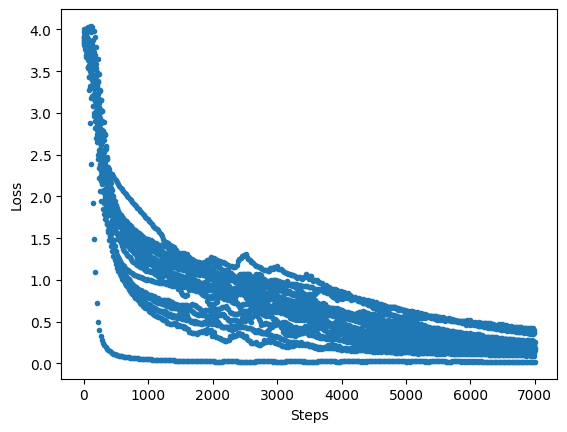

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_monitor.loss, '.')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

The method of printing the parameters of the quantum embedded layer is as follows:

In [13]:
net.embedding.weight.asnumpy()

array([ 8.11327994e-02, -3.34400564e-01, -1.23247825e-01,  5.81944704e-01,
       -4.20968421e-03,  3.15563884e-05,  2.42589042e-01,  8.80479038e-01,
       -1.43023849e-01, -6.37480104e-03,  2.73182592e-03,  1.65943671e-02,
        2.39036694e-01, -2.39808977e-01, -6.56178296e-01,  2.62607052e-03,
       -9.76558731e-05, -7.48617807e-03,  4.85512346e-01,  8.62547606e-02,
        1.09600239e-02, -1.94667071e-01,  5.48206130e-03,  2.82003220e-05,
        2.83775508e-01, -3.44718695e-01,  2.57234443e-02, -1.58091113e-01,
       -5.39550185e-03, -1.15225427e-02,  2.88938046e-01, -5.74903965e-01,
       -2.53041506e-01, -1.81123063e-01, -5.67151117e-04, -3.33190081e-03,
        3.47066782e-02,  2.39473388e-01,  1.34246838e+00, -9.32823777e-01,
        1.55618461e-03,  1.34847098e-04,  7.36262277e-02, -1.90044902e-02,
       -1.26371592e-01,  4.32286650e-01, -3.66644454e-05, -1.36820097e-02,
        7.11344108e-02, -3.02037269e-01, -1.80939063e-01,  4.20952231e-01,
       -6.96726423e-03, -

## Classical Word Embedding Layer

Here, we construct a classical CBOW neural network with the classical word embedding layer. This classical CBOW is compared with the quantum one.

Firstly, we construct the classical CBOW neural network and the parameters are similar to the ones in the quantum CBOW.

In [14]:
class CBOWClassical(nn.Cell):
    def __init__(self, num_embedding, embedding_dim, window, hidden_dim):
        super(CBOWClassical, self).__init__()
        self.dim = 2 * window * embedding_dim
        self.embedding = nn.Embedding(num_embedding, embedding_dim, True)
        self.dense1 = nn.Dense(self.dim, hidden_dim)
        self.dense2 = nn.Dense(hidden_dim, num_embedding)
        self.relu = ops.ReLU()
        self.reshape = ops.Reshape()

    def construct(self, x):
        embed = self.embedding(x)
        embed = self.reshape(embed, (-1, self.dim))
        out = self.dense1(embed)
        out = self.relu(out)
        out = self.dense2(out)
        return out

Generate the dataset for the classical CBOW neural network.

In [15]:
train_x = []
train_y = []
for i in sample:
    around, center = i
    train_y.append(word_dict[center])
    train_x.append([])
    for j in around:
        train_x[-1].append(word_dict[j])
train_x = np.array(train_x).astype(np.int32)
train_y = np.array(train_y).astype(np.int32)
print("train_x shape: ", train_x.shape)
print("train_y shape: ", train_y.shape)

train_x shape:  (58, 4)
train_y shape:  (58,)


Train the classical CBOW network.

In [16]:
ms.set_context(mode=ms.GRAPH_MODE, device_target="CPU")

train_loader = ds.NumpySlicesDataset({
    "around": train_x,
    "center": train_y
}, shuffle=False).batch(3)
net = CBOWClassical(len(word_dict), embedding_dim, window_size, hidden_dim)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(net.trainable_params(), 0.01, 0.9)
loss_monitor = LossMonitorWithCollection(500)
model = ms.Model(net, net_loss, net_opt)
model.train(350, train_loader, callbacks=[loss_monitor], dataset_sink_mode=False)

epoch:  25 step:  20 time: 0.022, loss is 0.627
epoch:  50 step:  20 time: 0.028, loss is 0.011
epoch:  75 step:  20 time: 0.026, loss is 0.003
epoch: 100 step:  20 time: 0.022, loss is 0.002
epoch: 125 step:  20 time: 0.017, loss is 0.001
epoch: 150 step:  20 time: 0.021, loss is 0.001
epoch: 175 step:  20 time: 0.027, loss is 0.000
epoch: 200 step:  20 time: 0.019, loss is 0.000
epoch: 225 step:  20 time: 0.019, loss is 0.000
epoch: 250 step:  20 time: 0.019, loss is 0.000
epoch: 275 step:  20 time: 0.018, loss is 0.000
epoch: 300 step:  20 time: 0.025, loss is 0.000
epoch: 325 step:  20 time: 0.018, loss is 0.000
epoch: 350 step:  20 time: 0.017, loss is 0.000
Total time used: 8.476526975631714


Print the loss value during convergence:

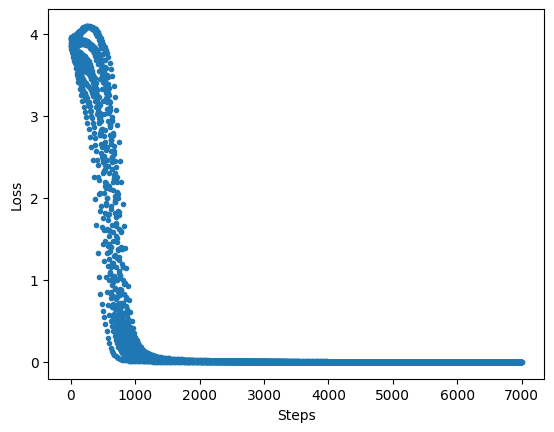

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_monitor.loss, '.')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

According to the above result, it can be seen that the quantum word embedding model generated by the quantum simulation can complete the word embedding task perfectly. When classical computers cannot handle the large quantity of data, the quantum computers can easily deal with large data.

In [18]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.10.1
numpy,1.23.5
System,Info
Python,3.9.16
OS,Linux x86_64
Memory,8.3 GB
CPU Max Thread,8
Date,Mon Jan 1 01:34:10 2024


## Reference

[1] Tomas Mikolov, Kai Chen, Greg Corrado, Jeffrey Dean. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)